Para obter as datas e horas de todas as emersões e ocultações de Io indicadas no ficheiro all_events.dat, obtidas com o stellarium

In [11]:
import requests
import datetime as dttm
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def get_ephem(start_time, stop_time, step_size):
    with open("horizons_script_templ.txt", 'r') as file:
        filedata = file.readlines()
    filedata[-3] = filedata[-3][:11] + "'" + str(start_time) + "'\n"
    filedata[-2] = filedata[-2][:10] + "'" + str(stop_time) + "'\n"
    filedata[-4] = filedata[-4][:10] + "'" + str(step_size) + "'\n"
    with open("horizons_script.txt", 'w') as file:
        file.writelines(filedata)
    with open("horizons_script.txt") as script:
        url = 'https://ssd.jpl.nasa.gov/api/horizons_file.api'
        r = requests.post(url, data={'format':'text'}, files={'input': script})
    return r.text


def get_partial_ss(ephem_text):
    ephem_lines = ephem_text.split('\n')
    start_line = next(line for line in ephem_lines if line[-2:].upper() == "/P")
    stop_line =  next(line for line in ephem_lines[::-1] if line[-2:].upper() == "/P")
    t1 = dttm.datetime.strptime(start_line[1:21],"%Y-%b-%d %H:%M:%S")
    t2 = dttm.datetime.strptime(stop_line[1:21],"%Y-%b-%d %H:%M:%S")
    return t1,t2
                      
#evtime = dttm.datetime.fromisoformat("2020-07-15 06:58:13")
#start_time = evtime-dttm.timedelta(minutes=3)
#stop_time = evtime+dttm.timedelta(minutes=3)
#start_time = dttm.datetime.fromisoformat("2020-07-15 06:56:10")
#stop_time  = dttm.datetime.fromisoformat("2020-07-15 07:00:00")
#ephem_txt = get_ephem(start_time, stop_time, 230)
#print(get_partial_ss(ephem_txt))


Esta célula determina os momentos das ocorrências registadas no ficheiro all_events.dat (determinadas com o stellarium), usando o sistema horizons da nasa/jpl. Já a executei uma vez, e os resultados (juntamente com os do stellarium para comparação) estão no ficheiro ste_vs_eph_times.dat. Como leva tempo, é melhor não executar outra vez esta célula.

In [13]:
with open("../data/all_events.dat",'r') as ste_datafile:
    ste_lines = ste_datafile.readlines()
result_lines = []
for line in ste_lines:
    first_char = line[0]
    if first_char not in "EO" or len(line.strip()) < 23:
        continue
    try:
        ste_time = dttm.datetime.fromisoformat(line[4:23])
    except ValueError:
        print('Format error at line:')
        print('>'+line+'<')
        continue
    start_time = ste_time - dttm.timedelta(minutes=4)
    stop_time  = ste_time + dttm.timedelta(minutes=4)
    step_size = int((stop_time - start_time).total_seconds())
    ephem_txt = get_ephem(start_time, stop_time, step_size)
    t1, t2 = get_partial_ss(ephem_txt)
    eph_time = t1 + (t2 - t1) / 2
    result_lines.append(first_char + '   ' + str(ste_time) + '   ' + str(eph_time))
rls = [line + '\n' for line in result_lines]
with open("../data/ste_vs_eph_times.dat",'w') as file:
    file.writelines(rls)

Como são os tempos calculados com o horizons? Vejamos gráficos.

In [41]:
with open("../data/ste_vs_eph_times.dat", 'r') as file:
    rls = file.readlines()

In [42]:
# Para o período sinódico de 2025
ste_te = [dttm.datetime.fromisoformat(line[4:23]) for line in rls[240:353]]
eph_te = [dttm.datetime.fromisoformat(line[26:45]) for line in rls[240:353]]
ste_to = [dttm.datetime.fromisoformat(line[4:23]) for line in rls[353:]]
eph_to = [dttm.datetime.fromisoformat(line[26:45]) for line in rls[353:]]

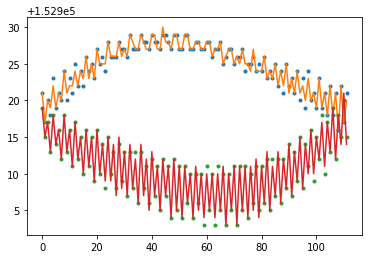

In [51]:
ste_dte = np.array([(t-ste_te[0]).total_seconds() for t in ste_te])
eph_dte = np.array([(t-eph_te[0]).total_seconds() for t in eph_te])
ste_dto = np.array([(t-ste_to[0]).total_seconds() for t in ste_to])
eph_dto = np.array([(t-eph_to[0]).total_seconds() for t in eph_to])
ste_Te = ste_dte[1:] - ste_dte[:-1]
eph_Te = eph_dte[1:] - eph_dte[:-1]
ste_To = ste_dto[1:] - ste_dto[:-1]
eph_To = eph_dto[1:] - eph_dto[:-1]
plt.plot(
    ste_dte[1:]-ste_dte[:-1],'.', eph_dte[1:]-eph_dte[:-1],'-',
    ste_dto[1:]-ste_dto[:-1],'.', eph_dto[1:]-eph_dto[:-1],'-');


A diferença entre os valores dos períodos entre emersões ou ocultações sucessivas, obtidos no stellarium ou pelo Horizons é no máximo 1 s:

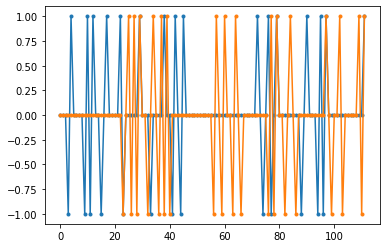

In [49]:
plt.plot(ste_Te-eph_Te,'.-', ste_To-eph_To,'.-');

Estas diferenças de +/- 1 s são perfeitamente justificáveis com as diferenças formas de calcular o isntante central. De facto, até me parece que se trata de erros de arredondamento. Os tempos do stellarium são lidos num formato que descarta as frações de segundo. Esta diferença deve resultar daí, apenas.